In [9]:
import ogr
import subprocess

import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# GDAL command line

## Example: reprojection

**GDAL** is a really powerful library for handling GIS data. It provides a number of functionalities to interact with spatial data. As a typical example, take the **reprojection** of a shapefile to another CRS:

In [2]:
!ogr2ogr ../scratch/deelbekkens_wgs84 -t_srs "EPSG:4326" ../data/deelbekkens/Deelbekken.shp

What is this combination of commands?

* `!` this is a jupyter notebook-thing, telling it we're running something on the command line instead of in Python
* `../scratch/deelbekkens_wgs84` the output location of the created file
* `-t_srs "EPSG:4326"` the CRS information for to which the data should be projected
* `../data/deelbekkens/Deelbekken.shp` the source file location

The documentation is a bit overwhelming:

In [4]:
!ogr2ogr --help

Usage: ogr2ogr [--help-general] [-skipfailures] [-append] [-update]
               [-select field_list] [-where restricted_where|@filename]
               [-progress] [-sql <sql statement>|@filename] [-dialect dialect]
               [-preserve_fid] [-fid FID]
               [-spat xmin ymin xmax ymax] [-spat_srs srs_def] [-geomfield field]
               [-a_srs srs_def] [-t_srs srs_def] [-s_srs srs_def]
               [-f format_name] [-overwrite] [[-dsco NAME=VALUE] ...]
               dst_datasource_name src_datasource_name
               [-lco NAME=VALUE] [-nln name] 
               [-nlt type|PROMOTE_TO_MULTI|CONVERT_TO_LINEAR]
               [-dim 2|3|layer_dim] [layer [layer ...]]

Advanced options :
               [-gt n] [-ds_transaction]
               [[-oo NAME=VALUE] ...] [[-doo NAME=VALUE] ...]
               [-clipsrc [xmin ymin xmax ymax]|WKT|datasource|spat_extent]
               [-clipsrcsql sql_statement] [-clipsrclayer layer]
               [-clipsrcwhere expressio

but there are [great online resources](https://github.com/dwtkns/gdal-cheat-sheet) with good examples you can easily copy paste for your own applications...

## Example 2: Accessing online webservice data (Web Feature Service - WFS)

A lot of expensive terminology... 

Let's illustrate this with an example: The information about municipalities is available as [open data on geopunt](http://www.geopunt.be/catalogus/webservicefolder/1/11c37274-f9db-526e-2067-6606-b324-23d1-f285dbe7) (coming from informatie Vlaanderen). The publication is provided as a [WFS service](http://docs.geoserver.org/stable/en/user/services/wfs/reference.html)... 

Take home message -> **GDAL can handle WFS web services** ;-)

Downloading the province boundaries from the WFS service provided by *informatie Vlaanderen/Geopunt* to a geojson file is as follows:

In [6]:
!ogr2ogr -f 'Geojson' ../scratch/provinces.geojson WFS:"https://geoservices.informatievlaanderen.be/overdrachtdiensten/VRBG/wfs" Refprv

We can start working with this date...

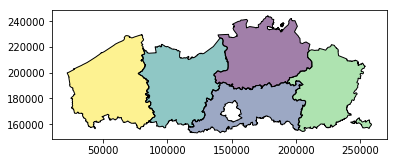

In [46]:
provinces = gpd.read_file("../scratch/provinces.geojson")
provinces.plot()

Actually, GDAL can directly **query the WFS data**:

Let's say I only need the province of `Antwerp`:

In [12]:
!ogr2ogr -f 'Geojson' ../scratch/antwerp_prov.geojson WFS:"https://geoservices.informatievlaanderen.be/overdrachtdiensten/VRBG/wfs" Refprv -where "NAAM = 'Antwerpen'"

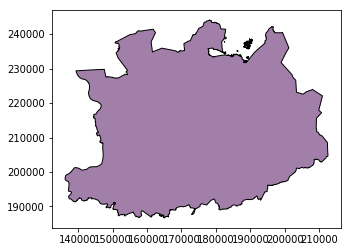

In [45]:
antwerp = gpd.read_file("../scratch/antwerp_prov.geojson")
antwerp.plot()

I do know that the [*Meetplaatsen Oppervlaktewaterkwaliteit*](http://www.geopunt.be/catalogus/webservicefolder/4/435c1aae-6619-0801-c317-2bf9-9f58-ce7f-e262a96c)  are also available as a WFS web service. However, I'm only interested in the locations for *fytoplankton*:

In [14]:
!ogr2ogr -f 'Geojson' ../scratch/metingen_fytoplankton.geojson WFS:"https://geoservices.informatievlaanderen.be/overdrachtdiensten/MeetplOppervlwaterkwal/wfs" Mtploppw -where "FYTOPLANKT = '1'"

In [16]:
import mplleaflet
fyto = gpd.read_file("../scratch/metingen_fytoplankton.geojson")
fyto.head()
fyto.to_crs('+init=epsg:4326').plot(markersize=5)
mplleaflet.display()

In [17]:
fyto.head()

,BACTERIO,FYSICOCHEM,FYTOBENT,FYTOPLANKT,MACROFYT,MACROINV,MAP_MEETNT,MEETPLNR,OIDN,OMSCHR,UIDN,WATBODEM,ZUURSTOF,geometry,gml_id
0,0,1,0,1,0,1,0,335000,160.0,"Gewad, opw brugje, thv Club Vrije Vissers",160.0,0,1,POINT (198585 204048),Mtploppw.120
1,0,1,0,1,0,1,1,336000,177.0,"Schoor; thv spoorweg (zandweg langs spoorweg),...",177.0,1,1,POINT (207151 205751),Mtploppw.137
2,1,1,0,1,0,1,0,340500,183.0,"RV: Battenbroek; Walem, ter hoogte van Blaren...",183.0,1,1,POINT (155148 195239),Mtploppw.143
3,0,1,0,1,0,1,1,969012,2622.0,"Reninge, Steenw Op Reninge-Noordschote",2622.0,0,1,POINT (39450 183350),Mtploppw.511
4,0,1,0,1,0,1,0,973075,2665.0,"Westouter, Langedreef zijweg",2665.0,0,1,POINT (35218 165357),Mtploppw.553


Actually, the same type of subselection are also possible on shapefiles,... 

Extracting a specific *DEELBEKKEN* from the deelbekken shapefile:

In [25]:
!ogr2ogr ../scratch/subcat.shp ../data/deelbekkens/Deelbekken.shp -where "DEELBEKKEN = '10-10'"

(If you're wondering how I know how to setup these commands and arguments, check the (draft) `introduction_webservices.ipynb` in the `scratch` folder. <br>
I use the python interafce of GDAL/OGR and the package [`owslib`](https://geopython.github.io/OWSLib/) to find out how to setup the arguments.)

# GDAL command line, but inside Python ?!?

## Clipping example

The example we will use is to **clip raster data using a shapefile**. We use a data set from [natural earth](http://www.naturalearthdata.com/downloads/50m-natural-earth-1/50m-natural-earth-i-with-shaded-relief/), which we will unzip to start working on it (off course using Python itself):

In [21]:
import zipfile
zip_ref = zipfile.ZipFile("../data/NE1_50m_SR.zip", 'r')
zip_ref.extractall("../scratch")
zip_ref.close()

The **GDAL** function that support the clipping of a raster file, is called [`gdalwarp`](http://www.gdal.org/gdalwarp.html). Again, the documentation looks rather overwhelming... Let's start with an example execution:

In [26]:
!gdalwarp ../scratch/NE1_50M_SR/NE1_50M_SR.tif ../scratch/cliptest.tif -cutline "../scratch/subcat.shp" -crop_to_cutline

Creating output file that is 13P x 3L.
Processing input file ../scratch/NE1_50M_SR/NE1_50M_SR.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


* `!` this is a jupyter notebook-thing, telling it we're running something on the command line instead of in Python
* `gdalwarp` is the GDAL command to use
* `../scratch/NE1_50M_SR/NE1_50M_SR.tif` the source file location
* `../scratch/cliptest.tif`  the output location of the created file
* `-cutline "../scratch/subcat.shp"` the shape file to cut the raster with
* `-crop_to_cutline` an additional argument to GDAL to make the clipping

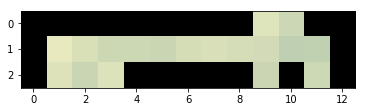

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img=mpimg.imread('../scratch/cliptest.tif')
plt.imshow(img)

This is off course a dummy example (to keep runtime low), but it illustrates the concept.

## the `subprocess` trick...

Doing the same using pure Python code and `from osgeo import gdal` is actually not so beneficial, as the command above is reather straighforward... However, the dependency of the command line provides a switch of environment in any data analysis pipeline. I actually do want to have the **best of both worlds**:
Using Python code, but running the command line version of GDAL...

...therefore we need `subprocess`!

In [32]:
import subprocess

Doing the same as above, but actually using Python code to run the command with given variables as input:

In [34]:
inraster = '../scratch/NE1_50M_SR/NE1_50M_SR.tif'
outraster = inraster.replace('.tif', '{}.tif'.format("_out")) # same location, but adding _out to the output 
inshape = "../scratch/subcat.shp"
subprocess.call(['gdalwarp', inraster, outraster, '-cutline', inshape, 
                     '-crop_to_cutline', '-overwrite'])

0

**Remark** when GDAL provides a zero as return statement, this is a GOOD sign!

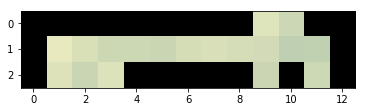

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img=mpimg.imread('../scratch/NE1_50M_SR/NE1_50M_SR_out.tif')
plt.imshow(img)

Hence, the result is the same, but calling the command from Python. By **writing a Python function** for this routine, I do have a reusable functionality in my toolbox that I can load in any other Python script:

In [42]:
def clip_raster(inraster, outraster, invector):
    """clip a raster image with a vector file
    
    Parameters
    ----------
    inraster : GDAL compatible raster format
    outraster : GDAL compatible raster format
    invector : GDAL compatible vector format
    """
    response = subprocess.call(['gdalwarp', inraster, outraster, '-cutline', 
                                invector, '-crop_to_cutline', '-overwrite'])
    return(response)    

In [43]:
inraster = '../scratch/NE1_50M_SR/NE1_50M_SR.tif'
outraster = inraster.replace('.tif', '{}.tif'.format("_out")) # same location, but adding _out to the output 
inshape = "../scratch/subcat.shp"
clip_raster(inraster, outraster, inshape)

0

## More advanced clipping

Consider the data set of the provinces we called from the WFS server earlier:

In [52]:
provinces

,NAAM,NISCODE,NUTS2,OIDN,TERRID,UIDN,geometry,gml_id
0,Antwerpen,10000,BE21,2.0,357,6.0,"(POLYGON ((178133.91 244025.6, 178125.41 24402...",Refprv.1
1,Vlaams Brabant,20001,BE24,4.0,359,7.0,"(POLYGON ((200484.928 193540.963625, 200484.79...",Refprv.2
2,Oost-Vlaanderen,40000,BE23,5.0,356,9.0,"(POLYGON ((142473.938 226522.156, 142360.719 2...",Refprv.3
3,Limburg,70000,BE22,1.0,355,10.0,"(POLYGON ((231635.609 218998.547, 231477.484 2...",Refprv.4
4,West-Vlaanderen,30000,BE25,3.0,351,11.0,"(POLYGON ((80189.158375 229275.081, 80038.5202...",Refprv.5


We can actually use a selection of the provinces data set to execute the clipping:

In [54]:
inraster = '../scratch/NE1_50M_SR/NE1_50M_SR.tif'
outraster = inraster.replace('.tif', '{}.tif'.format("_OostVlaanderen"))    
invector = "../scratch/provinces.geojson"
subprocess.call(['gdalwarp', inraster, outraster, '-cutline', invector, 
                 '-cwhere', "NAAM='OOST-VLAANDEREN'", 
                 '-crop_to_cutline', 
                 '-overwrite'])

0

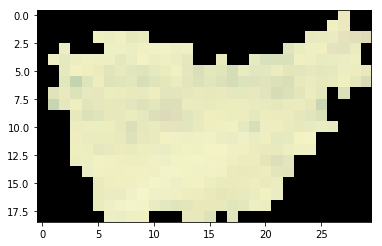

In [55]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img=mpimg.imread('../scratch/NE1_50M_SR/NE1_50M_SR_OostVlaanderen.tif')
plt.imshow(img)

By having it as a Python call, we can do the same action for each of the individual provinces in the dataset and **create for each of the provinces a clipped raster data set**:

In [57]:
import ogr

inraster = '../scratch/NE1_50M_SR/NE1_50M_SR.tif'
invector = "../scratch/provinces.geojson"

# GDAL magic...
ds = ogr.Open(inshape)
lyr = ds.GetLayer(0)

lyr.ResetReading()
ft = lyr.GetNextFeature()

# clipping for each of the features (provincesin this case)
while ft:

    province_name = ft.GetFieldAsString('NAAM')
    print(province_name)

    outraster = inraster.replace('.tif', '_%s.tif' % province_name.replace('-', '_'))    
    subprocess.call(['gdalwarp', inraster, outraster, '-cutline', inshape, 
                     '-crop_to_cutline', '-cwhere', "NAAM='%s'" %province_name])

    ft = lyr.GetNextFeature()

ds = None

Antwerpen
Vlaams Brabant
Oost-Vlaanderen
Limburg
West-Vlaanderen


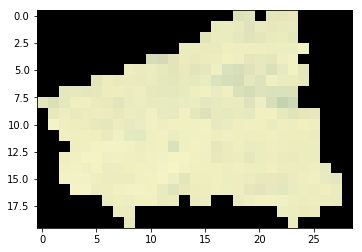

In [59]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img=mpimg.imread('../scratch/NE1_50M_SR/NE1_50M_SR_West_Vlaanderen.tif') # check also Antwerpen,...
plt.imshow(img)